In [71]:
import numpy as np
import nolearn
import sklearn.linear_model as lm
import scipy.stats as sps
import math

from decimal import Decimal
from lasagne import layers, nonlinearities
from lasagne.updates import nesterov_momentum
from lasagne import layers
from nolearn.lasagne import NeuralNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR
from sklearn.externals import joblib

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import custom_funcs as cf
cf.init_seaborn('white', 'poster')
from isoelectric_point import isoelectric_points
from molecular_weight import molecular_weights

In [11]:
# Read in the protease inhibitor data
data, drug_cols, feat_cols = cf.read_data('hiv-protease-data.csv', n_data_cols=8)

# Read in the consensus data
consensus_map = cf.read_consensus('hiv-protease-consensus.fasta')

# Clean the data
data = cf.clean_data(data, feat_cols, consensus_map)

# Identify non-conserved calls
nonconserved_cols = cf.identify_nonconserved_cols(data, feat_cols)
data = cf.drop_ambiguous_sequences(data, nonconserved_cols)
data = cf.drop_conserved_cols(data, feat_cols, nonconserved_cols)
data

,FPV,ATV,IDV,LPV,NFV,SQV,TPV,DRV,P2,P3,...,P89,P90,P91,P92,P93,P94,P95,P96,P97,P98
SeqID,,,,,,,,,,,,,,,,,,,,,
27960,2.5,3.2,2.0,3.9,4.4,0.8,8.4,1.1,Q,I,...,L,L,T,Q,L,G,C,T,L,N
50921,47.0,9.6,124.0,500.0,24.0,1.0,4.0,11.0,Q,I,...,L,M,T,K,L,G,C,T,L,N
56746,1.2,1.5,1.0,0.8,1.2,0.7,1.6,1.2,Q,I,...,L,L,T,Q,L,G,C,T,L,N
60717,8.1,6.5,2.7,16.0,6.9,0.9,12.0,2.8,Q,I,...,L,L,T,Q,L,G,C,T,L,N
86662,14.0,51.0,104.0,76.0,191.0,24.0,3.3,2.3,Q,I,...,L,M,T,Q,L,G,F,T,L,N
86676,4.1,46.0,57.0,58.0,12.0,1000.0,16.0,3.9,Q,I,...,L,L,T,R,I,G,C,T,L,N
86690,19.0,85.0,49.0,114.0,70.0,45.0,1.3,15.0,Q,I,...,L,L,S,Q,I,G,C,T,L,N
86834,400.0,53.0,33.0,76.0,53.0,62.0,200.0,36.0,Q,I,...,L,M,T,Q,L,G,C,T,L,N
89038,5.6,98.0,16.0,49.0,149.0,29.0,1.6,0.8,Q,I,...,L,L,T,Q,L,G,C,T,L,N


In [40]:
# consensus_map

In [64]:
print(drug_cols)

DRUG = 'ATV'

Index(['FPV', 'ATV', 'IDV', 'LPV', 'NFV', 'SQV', 'TPV', 'DRV'], dtype='object')


In [75]:
# Split data into predictor variables and dependent variables.
# Predictors are the sequence features
# Dependent are the drug resistance values
X, Y = cf.split_data_xy(data, nonconserved_cols, DRUG)

# Binarize the sequence features
X_binarized, X_binarizers = cf.binarize_seqfeature(X)

In [78]:
joblib.dump(X_binarizers, 'models/binarizer.pkl')

['models/binarizer.pkl',
 'models/binarizer.pkl_01.npy',
 'models/binarizer.pkl_02.npy',
 'models/binarizer.pkl_03.npy',
 'models/binarizer.pkl_04.npy',
 'models/binarizer.pkl_05.npy',
 'models/binarizer.pkl_06.npy',
 'models/binarizer.pkl_07.npy',
 'models/binarizer.pkl_08.npy',
 'models/binarizer.pkl_09.npy',
 'models/binarizer.pkl_10.npy',
 'models/binarizer.pkl_11.npy',
 'models/binarizer.pkl_12.npy',
 'models/binarizer.pkl_13.npy',
 'models/binarizer.pkl_14.npy',
 'models/binarizer.pkl_15.npy',
 'models/binarizer.pkl_16.npy',
 'models/binarizer.pkl_17.npy',
 'models/binarizer.pkl_18.npy',
 'models/binarizer.pkl_19.npy',
 'models/binarizer.pkl_20.npy',
 'models/binarizer.pkl_21.npy',
 'models/binarizer.pkl_22.npy',
 'models/binarizer.pkl_23.npy',
 'models/binarizer.pkl_24.npy',
 'models/binarizer.pkl_25.npy',
 'models/binarizer.pkl_26.npy',
 'models/binarizer.pkl_27.npy',
 'models/binarizer.pkl_28.npy',
 'models/binarizer.pkl_29.npy',
 'models/binarizer.pkl_30.npy',
 'models/binari

In [66]:
X_binarized

,P2_Q,P3_F,P3_I,P3_L,P3_M,P4,P5_L,P6,P7,P8_R,...,P92_Q,P92_R,P93,P94_G,P95_C,P95_F,P95_G,P96_T,P97_L,P98_N
0,0,0,1,0,0,1,0,1,0,0,...,1,0,1,0,1,0,0,0,0,0
1,0,0,1,0,0,1,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,1,0,0,1,0,1,0,0,...,1,0,1,0,1,0,0,0,0,0
3,0,0,1,0,0,1,0,1,0,0,...,1,0,1,0,1,0,0,0,0,0
4,0,0,1,0,0,1,0,1,0,0,...,1,0,1,0,0,1,0,0,0,0
5,0,0,1,0,0,1,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
6,0,0,1,0,0,1,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
7,0,0,1,0,0,1,0,1,0,0,...,1,0,1,0,1,0,0,0,0,0
8,0,0,1,0,0,1,0,1,0,0,...,1,0,1,0,1,0,0,0,0,0
9,0,0,1,0,0,1,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0


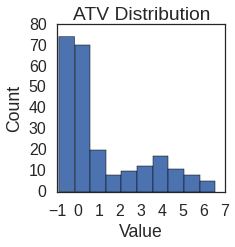

In [67]:
# View distribution of drug resistance values
import matplotlib.pyplot as plt
std = (3,3)
fig = cf.plot_Y_histogram(Y, DRUG, figsize=std)

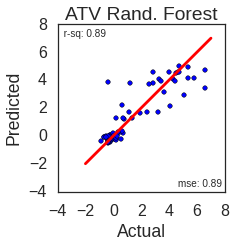

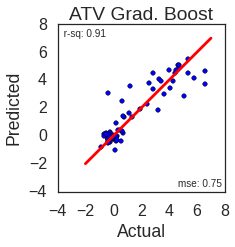

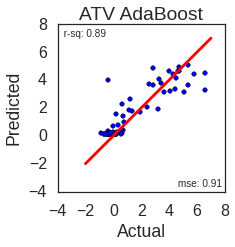

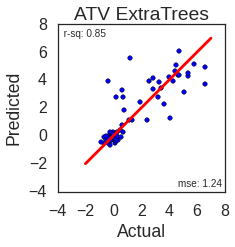

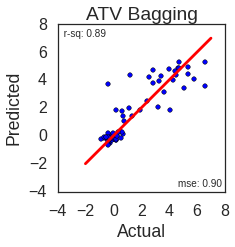

In [68]:
# Split data into training and testing set.
tts_data = X_train, X_test, Y_train, Y_test = train_test_split(X_binarized, Y, test_size=0.33)

# Train a bunch of ensemble regressors:
## Random Forest
kwargs = {'n_jobs':-1, 'n_estimators':1000}
rfr, rfr_preds, rfr_mse, rfr_r2 = cf.train_model(*tts_data, model=RandomForestRegressor, modelargs=kwargs)
## Gradient Boosting
kwargs = {'n_estimators':1000}
gbr, gbr_preds, gbr_mse, gbr_r2 = cf.train_model(*tts_data, model=GradientBoostingRegressor, modelargs=kwargs)
## AdaBoost
kwargs = {'n_estimators':1000}
abr, abr_preds, abr_mse, abr_r2 = cf.train_model(*tts_data, model=AdaBoostRegressor, modelargs=kwargs)
## ExtraTrees
kwargs = {'n_estimators':1000, 'n_jobs':-1}
etr, etr_preds, etr_mse, etr_r2 = cf.train_model(*tts_data, model=ExtraTreesRegressor, modelargs=kwargs)
## Bagging
bgr, bgr_preds, bgr_mse, bgr_r2 = cf.train_model(*tts_data, model=BaggingRegressor)

# Plot the results of regression
cf.scatterplot_results(rfr_preds, Y_test, rfr_mse, rfr_r2, DRUG, 'Rand. Forest', figsize=std)
plt.savefig('figures/{0} random_forest_poster.pdf'.format(DRUG), bbox_inches='tight')
cf.scatterplot_results(gbr_preds, Y_test, gbr_mse, gbr_r2, DRUG, 'Grad. Boost', figsize=std)
plt.savefig('figures/{0} gradient_boost_poster.pdf'.format(DRUG), bbox_inches='tight')
cf.scatterplot_results(abr_preds, Y_test, abr_mse, abr_r2, DRUG, 'AdaBoost', figsize=std)
plt.savefig('figures/{0} adaboost_poster.pdf'.format(DRUG), bbox_inches='tight')
cf.scatterplot_results(etr_preds, Y_test, etr_mse, etr_r2, DRUG, 'ExtraTrees', figsize=std)
plt.savefig('figures/{0} extratrees_poster.pdf'.format(DRUG), bbox_inches='tight')
cf.scatterplot_results(bgr_preds, Y_test, bgr_mse, bgr_r2, DRUG, 'Bagging', figsize=std)
plt.savefig('figures/{0} bagging_poster.pdf'.format(DRUG), bbox_inches='tight')

In [73]:
# Save the models to disk

joblib.dump(rfr, 'models/{0} random_forest.pkl'.format(DRUG))
joblib.dump(abr, 'models/{0} adaboost.pkl'.format(DRUG))
joblib.dump(etr, 'models/{0} extratrees.pkl'.format(DRUG))
joblib.dump(gbr, 'models/{0} gradient_boost.pkl'.format(DRUG))
joblib.dump(bgr, 'models/{0} bagging.pkl'.format(DRUG))

['models/ATV bagging.pkl',
 'models/ATV bagging.pkl_01.npy',
 'models/ATV bagging.pkl_02.npy',
 'models/ATV bagging.pkl_03.npy',
 'models/ATV bagging.pkl_04.npy',
 'models/ATV bagging.pkl_05.npy',
 'models/ATV bagging.pkl_06.npy',
 'models/ATV bagging.pkl_07.npy',
 'models/ATV bagging.pkl_08.npy',
 'models/ATV bagging.pkl_09.npy',
 'models/ATV bagging.pkl_10.npy',
 'models/ATV bagging.pkl_11.npy',
 'models/ATV bagging.pkl_12.npy',
 'models/ATV bagging.pkl_13.npy',
 'models/ATV bagging.pkl_14.npy',
 'models/ATV bagging.pkl_15.npy',
 'models/ATV bagging.pkl_16.npy',
 'models/ATV bagging.pkl_17.npy',
 'models/ATV bagging.pkl_18.npy',
 'models/ATV bagging.pkl_19.npy',
 'models/ATV bagging.pkl_20.npy',
 'models/ATV bagging.pkl_21.npy',
 'models/ATV bagging.pkl_22.npy',
 'models/ATV bagging.pkl_23.npy',
 'models/ATV bagging.pkl_24.npy',
 'models/ATV bagging.pkl_25.npy',
 'models/ATV bagging.pkl_26.npy',
 'models/ATV bagging.pkl_27.npy',
 'models/ATV bagging.pkl_28.npy',
 'models/ATV bagging.

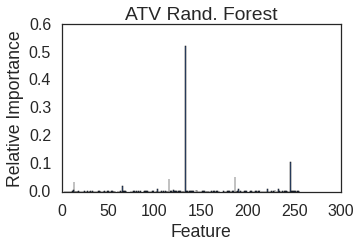

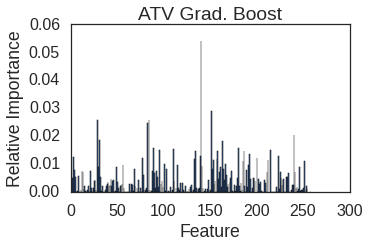

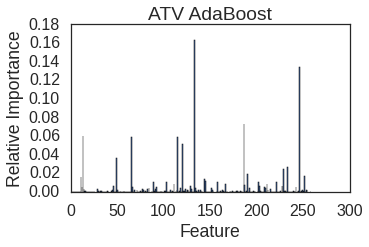

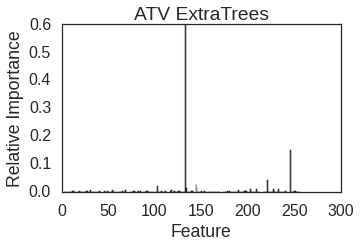

In [69]:
# Grab the feature importances - that is, how important a particular feature is for predicting drug resistance
cf.barplot_feature_importances(rfr, DRUG, 'Rand. Forest', figsize=(5,3))
plt.savefig('figures/{0} random_forest_feat_impt.pdf'.format(DRUG), bbox_inches='tight')
cf.barplot_feature_importances(gbr, DRUG, 'Grad. Boost', figsize=(5,3))
plt.savefig('figures/{0} gradient_boost_feat_impt.pdf'.format(DRUG), bbox_inches='tight')
cf.barplot_feature_importances(abr, DRUG, 'AdaBoost', figsize=(5,3))
plt.savefig('figures/{0} adaboost_feat_impt.pdf'.format(DRUG), bbox_inches='tight')
cf.barplot_feature_importances(etr, DRUG, 'ExtraTrees', figsize=(5,3))
plt.savefig('figures/{0} extratrees_feat_impt.pdf'.format(DRUG), bbox_inches='tight')
# cf.barplot_feature_importances(bgr, DRUG, 'Bagging') ## feature_importances_ do not exist for bagging

In [70]:
# Extract a table version of feature importance
rfr_fi = cf.extract_mutational_importance(rfr, X_test)
gbr_fi = cf.extract_mutational_importance(gbr, X_test)
abr_fi = cf.extract_mutational_importance(abr, X_test)

# Join data to compare random forest and gradient boosting.
# joined = rfr_fi.set_index(0).join(gbr_fi.set_index(0), lsuffix='r', rsuffix='g')
# sps.spearmanr(joined['1r'], joined['1g'])

rfr_fi

,0,1
0,P54_I,0.520666
1,P90,0.107630
2,P71_A,0.050899
3,P46_M,0.043606
4,P10_L,0.035629
5,P32,0.020559
6,P71_V,0.011093
7,P84,0.009952
8,P41_R,0.009623
9,P82_A,0.007554


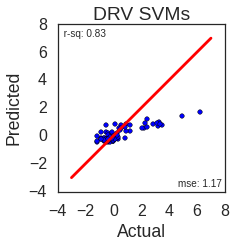

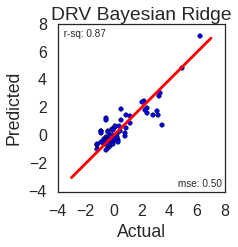

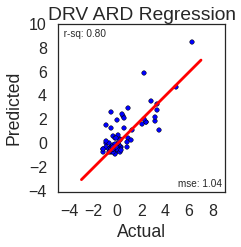

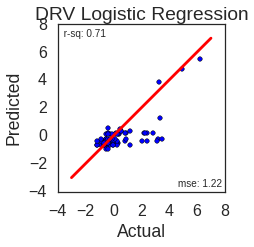

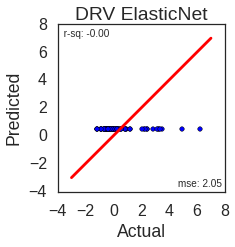

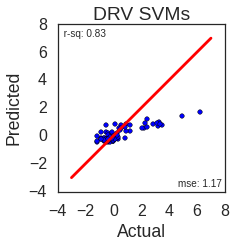

In [61]:
# Train a bunch of linear model learners for comparison.
brr, brr_preds, brr_mse, brr_r2 = cf.train_model(*tts_data, model=lm.BayesianRidge)
ard, ard_preds, ard_mse, ard_r2 = cf.train_model(*tts_data, model=lm.ARDRegression)
logr, logr_preds, logr_mse, logr_r2 = cf.train_model(*tts_data, model=lm.LogisticRegression)
enr, enr_preds, enr_mse, enr_r2 = cf.train_model(*tts_data, model=lm.ElasticNet)
svr, svr_preds, svr_mse, svr_r2 = cf.train_model(*tts_data, model=SVR)

# Likewise, plot the results
cf.scatterplot_results(brr_preds, Y_test, brr_mse, brr_r2, DRUG, 'Bayesian Ridge', figsize=std)
cf.scatterplot_results(ard_preds, Y_test, ard_mse, ard_r2, DRUG, 'ARD Regression', figsize=std)
cf.scatterplot_results(logr_preds, Y_test, logr_mse, logr_r2, DRUG, 'Logistic Regression', figsize=std)
cf.scatterplot_results(enr_preds, Y_test, enr_mse, enr_r2, DRUG, 'ElasticNet', figsize=std)
cf.scatterplot_results(svr_preds, Y_test, svr_mse, svr_r2, DRUG, 'SVMs', figsize=std)

In [62]:
# Let's now try a neural network. 
# Neural Network 1 Specification: Feed Forward ANN with 1 hidden layer.

x_train = X_train.astype(np.float32)
y_train = Y_train.astype(np.float32)
x_test = X_test.astype(np.float32)
y_test = Y_test.astype(np.float32)

net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden1', layers.DenseLayer),
        ('dropout1', layers.DropoutLayer),
        #('hidden2', layers.DenseLayer),
        #('dropout2', layers.DropoutLayer),
        ('nonlinear', layers.NonlinearityLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, x_train.shape[1]),  # 
    hidden1_num_units=math.ceil(x_train.shape[1] / 2),  # number of units in hidden layer
    hidden1_nonlinearity=nonlinearities.tanh,
    dropout1_p = 0.5,
    #hidden2_num_units=math.ceil(x_train.shape[1] / 2),
    #dropout2_p = 0.5,
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=1,  # 30 target values
    
    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.95,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=500,  # we want to train this many epochs
    verbose=1,
    )
net1.fit(x_train.values, y_train.values)

# Neural Network with 33931 learnable parameters

## Layer information

  #  name         size
---  ---------  ------
  0  input         259
  1  hidden1       130
  2  dropout1      130
  3  nonlinear     130
  4  output          1

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       3.50917       1.12961      3.10653  0.00s
      2       3.10456       1.07732      2.88174  0.00s
      3       2.95407       0.93296      3.16633  0.00s
      4       2.55935       0.76139      3.36143  0.00s
      5       2.26012       0.66059      3.42138  0.00s
      6       2.07630       0.55004      3.77485  0.00s
      7       1.82354       0.54596      3.34007  0.00s
      8       1.35817       0.48867      2.77929  0.00s
      9       1.41044       0.42833      3.29289  0.00s
     10       1.52635       0.41672      3.66274  0.00s
     11       1.14539       0.39505      2.89938  0.00s
     12       1.08308       0.38861     

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f4d987796d8>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f4d987794e0>,
     custom_score=None, dropout1_p=0.5,
     hidden1_nonlinearity=<function tanh at 0x7f4d57c13378>,
     hidden1_num_units=130, input_shape=(None, 259),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden1', <class 'lasagne.layers.dense.DenseLayer'>), ('dropout1', <class 'lasagne.layers.noise.DropoutLayer'>), ('nonlinear', <class 'lasagne.layers.dense.NonlinearityLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=500, more_params={},
     objective=<function objective at 0x7f4d9877b8c8>,
     objective_loss_function=<function squared_error at 0x7f4d57c38bf8>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog object at 0x7f4d18904c18>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.

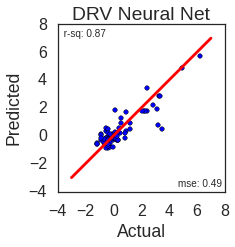

In [63]:
# And now let's also look at whether it looks good or not.
nn1_preds = net1.predict(x_test)
nn1_mse = float(mean_squared_error(nn1_preds, y_test))
nn1_r2 = float(sps.pearsonr(nn1_preds, y_test.reshape(y_test.shape[0],1))[0][0])

cf.scatterplot_results(nn1_preds, y_test, nn1_mse, nn1_r2, DRUG, 'Neural Net', figsize=std)
plt.savefig('figures/{0} neural_net_poster.pdf'.format(DRUG), bbox_inches='tight')